# Quora Question pair similarity

In [77]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, roc_curve
import xgboost as xgb
from matplotlib import pyplot as plt

In [3]:
from nltk.corpus import stopwords
import re

STOP_WORDS = stopwords.words("english")

# Load data

In [ ]:
path = r'C:\Users\Friend\AI\AI_datasets\Quora'

data = pd.read_csv(os.path.join(path,"nlp_features_train.csv"),encoding='latin-1')
data = data[0:10000]
data['question1'] = data['question1'].apply(lambda x: str(x))
data['question2'] = data['question2'].apply(lambda x: str(x))

In [45]:
#nlp_features_train.csv (NLP Features)

if os.path.isfile(os.path.join(path,'nlp_features_train.csv')):
    dfnlp = pd.read_csv(os.path.join(path,"nlp_features_train.csv"),encoding='latin-1')
    dfnlp = dfnlp.fillna('')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df1.shape

(10000, 17)

In [46]:
#prepro_features_train.csv (Simple Preprocessing Feartures)

if os.path.isfile(os.path.join(path,'data_fe_without_preprocessing_train.csv')):
    dfppro = pd.read_csv(os.path.join(path,"data_fe_without_preprocessing_train.csv"),encoding='latin-1')
    dfppro = dfppro.fillna('')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")
    
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2.shape

(10000, 12)

In [62]:
df12  = df1.merge(df2, on='id',how='left')

df12_train = df12[0:8001]
df12_test = df12[8001:10000]

In [5]:
# merge texts
question1 = list(data['question1'])
question1_train = question1[0:int(len(question1)*0.8)+1]
question1_test = question1[int(len(question1)*0.8)+1:len(question1)]

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(lowercase=False,ngram_range=(1,2))
tf_idf_train = tf_idf_vect.fit_transform(question1_train)
tf_idf_test = tf_idf_vect.transform(question1_test)

In [7]:
#get tf_idf feature names
tfidf_feat = tf_idf_vect.get_feature_names()

In [9]:
i=0
list_of_sent=[]
for sent in question1_train:
    words = sent.split()
    processed_words = []
    for word in words:
        if word not in STOP_WORDS:
            remove_char = re.sub('[^A-Za-z0-9]+', '', word)
            processed_words.append(remove_char)
    list_of_sent.append(processed_words)
    
from gensim.models import Word2Vec

#word2vec
w2v_model = Word2Vec(list_of_sent,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

#tfidf wieghted vector
tfidf_sent_vectors_train = [];
row=0;
for sent in list_of_sent: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            if len(word)>1:
                if(word in tfidf_feat):
                    tf_idf = tf_idf_train[row, tfidf_feat.index(word)]
                    sent_vec += (vec * tf_idf)
                    weight_sum += tf_idf
                else:
                    tf_idf = 0
                    sent_vec += (vec * tf_idf)
                    weight_sum += tf_idf
        else:
            continue
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

In [29]:
ques1_train = tfidf_sent_vectors_train

In [30]:
len(ques1_train)

8001

In [20]:
i=0
list_of_sent=[]
for sent in question1_test:
    words = sent.split()
    processed_words = []
    for word in words:
        if word not in STOP_WORDS:
            remove_char = re.sub('[^A-Za-z0-9]+', '', word)
            processed_words.append(remove_char)
    list_of_sent.append(processed_words)
    
from gensim.models import Word2Vec

#word2vec
w2v_model = Word2Vec(list_of_sent,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

#tfidf wieghted vector
tfidf_sent_vectors_test = [];
row=0;
for sent in list_of_sent: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            if len(word)>1:
                if(word in tfidf_feat):
                    tf_idf = tf_idf_test[row, tfidf_feat.index(word)]
                    sent_vec += (vec * tf_idf)
                    weight_sum += tf_idf
                else:
                    tf_idf = 0
                    sent_vec += (vec * tf_idf)
                    weight_sum += tf_idf
        else:
            continue
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [26]:
ques1_test = tfidf_sent_vectors_test

In [28]:
len(ques1_test)

1999

In [ ]:
question2 = list(data['question2'])
question2_train = question1[0:int(len(question2)*0.8)+1]
question2_test = question1[int(len(question2)*0.8)+1:len(question2)]

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(lowercase=False,ngram_range=(1,2))
tf_idf_train = tf_idf_vect.fit_transform(question2_train)
tf_idf_test = tf_idf_vect.transform(question2_test)

In [32]:
#get tf_idf feature names
tfidf_feat = tf_idf_vect.get_feature_names()

In [34]:
i=0
list_of_sent=[]
for sent in question2_train:
    words = sent.split()
    processed_words = []
    for word in words:
        if word not in STOP_WORDS:
            remove_char = re.sub('[^A-Za-z0-9]+', '', word)
            processed_words.append(remove_char)
    list_of_sent.append(processed_words)
    
from gensim.models import Word2Vec

#word2vec
w2v_model = Word2Vec(list_of_sent,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

#tfidf wieghted vector
tfidf_sent_vectors_train = [];
row=0;
for sent in list_of_sent: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            if len(word)>1:
                if(word in tfidf_feat):
                    tf_idf = tf_idf_train[row, tfidf_feat.index(word)]
                    sent_vec += (vec * tf_idf)
                    weight_sum += tf_idf
                else:
                    tf_idf = 0
                    sent_vec += (vec * tf_idf)
                    weight_sum += tf_idf
        else:
            continue
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

In [35]:
ques2_train = tfidf_sent_vectors_train

In [36]:
len(ques2_train)

8001

In [37]:
i=0
list_of_sent=[]
for sent in question1_test:
    words = sent.split()
    processed_words = []
    for word in words:
        if word not in STOP_WORDS:
            remove_char = re.sub('[^A-Za-z0-9]+', '', word)
            processed_words.append(remove_char)
    list_of_sent.append(processed_words)
    
from gensim.models import Word2Vec

#word2vec
w2v_model = Word2Vec(list_of_sent,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

#tfidf wieghted vector
tfidf_sent_vectors_test = [];
row=0;
for sent in list_of_sent: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            if len(word)>1:
                if(word in tfidf_feat):
                    tf_idf = tf_idf_test[row, tfidf_feat.index(word)]
                    sent_vec += (vec * tf_idf)
                    weight_sum += tf_idf
                else:
                    tf_idf = 0
                    sent_vec += (vec * tf_idf)
                    weight_sum += tf_idf
        else:
            continue
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [38]:
ques2_test = tfidf_sent_vectors_test

In [40]:
df3_train = pd.DataFrame(ques1_train)
df3_test = pd.DataFrame(ques1_test)

df4_train = pd.DataFrame(ques2_train)
df4_test = pd.DataFrame(ques2_test)

In [64]:
df3_train['id'] = [x for x in range(0,df12_train.shape[0])]
df4_train['id'] = [x for x in range(0,df12_train.shape[0])]

In [68]:
df34_train  = df3_train.merge(df4_train, on='id',how='left')
finaldata_train = df12_train.merge(df34_train, on='id',how='left')

y_train = finaldata_train['is_duplicate']
finaldata_train.drop(['id','is_duplicate'], axis=1, inplace=True)

X_train = finaldata_train[0:8001] 
y_train = y_train[0:8001]

print(X_train.shape,y_train.shape)

(8001, 126) (8001,)


In [70]:
df3_test['id'] = [x for x in range(8001,8001+df12_test.shape[0])]
df4_test['id'] = [x for x in range(8001,8001+df12_test.shape[0])]

In [73]:
df34_test  = df3_test.merge(df4_test, on='id',how='left')
finaldata_test = df12_test.merge(df34_test, on='id',how='left')

y_test = finaldata_test['is_duplicate']
finaldata_test.drop(['id','is_duplicate'], axis=1, inplace=True)

X_test = finaldata_test[0:20000]
y_test = y_test[0:20000]

print(X_test.shape,y_test.shape)

(1999, 126) (1999,)


# Standardize data

In [74]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
vocab = scaler.fit(X_train)
X_train = vocab.transform(X_train)
X_test = vocab.transform(X_test)

# XGBoost : ML model

In [84]:
max_depth = [4,8,10,50,100]
log_error_array = []

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02

for depth in max_depth:
    params['max_depth'] = depth
    d_train = xgb.DMatrix(X_train, label=y_train)
    d_test = xgb.DMatrix(X_test, label=y_test)    
    watchlist = [(d_train, 'train'), (d_test, 'valid')]    
    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=10, verbose_eval=10)    
    xgdmat = xgb.DMatrix(X_train,y_train)
    predict_y = bst.predict(d_test)
    log_error_array.append(log_loss(y_test, predict_y,  eps=1e-15))

[06:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-logloss:0.684962	valid-logloss:0.68494
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[06:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:07:40] src/t

[06:07:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:07:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:07:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:07:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:07:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:07:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:07:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:07:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:07:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[06:07:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[06:07:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[06:07:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[06:07:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:07:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[06:07:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[06:07:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[06:07:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[06:07:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[06:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[06:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[06:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[06:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[06:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[06:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[06:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[06:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[06:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[06:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[06:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[06:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[06:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[06:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[06:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=8
[06:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=8
[06:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[06:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[06:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[06:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[06:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[06:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=8
[40]	train-logloss:0.442465	valid-logloss:0.498407
[06:07:51] src/tree/updater_prune.cc:74: tree

[06:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[06:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=8
[06:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=8
[06:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[06:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=8
[06:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=8
[06:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=8
[110]	train-logloss:0.307401	valid-logloss:0.411633
[06:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=8
[06:07:55] src/tree/updater_prune.cc:74: tre

[06:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=8
[06:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[06:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[06:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=8
[06:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[06:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=8
[180]	train-logloss:0.261446	valid-logloss:0.389856
[06:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[06:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[06:07:59] src/tree/updater_prune.cc:74: tree pru

[06:08:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[06:08:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[06:08:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[06:08:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[06:08:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[06:08:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[30]	train-logloss:0.457833	valid-logloss:0.531407
[06:08:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[06:08:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[06:08:03] src/tree/updater_prune.cc:

[06:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[06:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[06:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[06:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=10
[06:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[06:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[06:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[100]	train-logloss:0.267275	valid-logloss:0.424313
[06:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[06:08:08] src/tree/updater_prune.cc

[06:08:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[06:08:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[06:08:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[06:08:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[06:08:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[06:08:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10
[06:08:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[06:08:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[170]	train-logloss:0.197158	valid-logloss:0.396958
[06:08:13] src/tree/updater_prune.cc

[06:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[06:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[06:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[06:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[06:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[06:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[240]	train-logloss:0.1623	valid-logloss:0.390907
[06:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[06:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[06:08:18] src/tree/updater_prune.cc:74: t

[06:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 972 extra nodes, 0 pruned nodes, max_depth=24
[06:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 946 extra nodes, 0 pruned nodes, max_depth=25
[06:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 944 extra nodes, 0 pruned nodes, max_depth=26
[06:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 968 extra nodes, 0 pruned nodes, max_depth=24
[06:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 928 extra nodes, 0 pruned nodes, max_depth=24
[06:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 966 extra nodes, 0 pruned nodes, max_depth=24
[50]	train-logloss:0.297399	valid-logloss:0.490231
[06:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 956 extra nodes, 0 pruned nodes, max_depth=26
[06:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 920 extra nodes, 0 pruned nodes, max_depth=27
[06:08:26] src/tree/updater_prune.cc:

[06:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 764 extra nodes, 0 pruned nodes, max_depth=25
[06:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 726 extra nodes, 0 pruned nodes, max_depth=19
[06:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 762 extra nodes, 0 pruned nodes, max_depth=27
[06:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 714 extra nodes, 0 pruned nodes, max_depth=25
[06:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 738 extra nodes, 0 pruned nodes, max_depth=22
[06:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 712 extra nodes, 0 pruned nodes, max_depth=25
[120]	train-logloss:0.128832	valid-logloss:0.424609
[06:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 746 extra nodes, 0 pruned nodes, max_depth=21
[06:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 726 extra nodes, 0 pruned nodes, max_depth=27
[06:08:35] src/tree/updater_prune.cc

[06:08:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 554 extra nodes, 0 pruned nodes, max_depth=28
[06:08:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=23
[06:08:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 560 extra nodes, 0 pruned nodes, max_depth=25
[06:08:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=20
[06:08:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 540 extra nodes, 0 pruned nodes, max_depth=22
[06:08:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 pruned nodes, max_depth=22
[06:08:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 532 extra nodes, 0 pruned nodes, max_depth=20
[190]	train-logloss:0.071551	valid-logloss:0.413185
[06:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 0 pruned nodes, max_depth=24
[06:08:44] src/tree/updater_prune.cc

[06:08:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 924 extra nodes, 0 pruned nodes, max_depth=24
[30]	train-logloss:0.400144	valid-logloss:0.539282
[06:08:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 906 extra nodes, 0 pruned nodes, max_depth=25
[06:08:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 924 extra nodes, 0 pruned nodes, max_depth=24
[06:08:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 954 extra nodes, 0 pruned nodes, max_depth=24
[06:08:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 960 extra nodes, 0 pruned nodes, max_depth=23
[06:08:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 944 extra nodes, 0 pruned nodes, max_depth=24
[06:08:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 950 extra nodes, 0 pruned nodes, max_depth=25
[06:08:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 946 extra nodes, 0 pruned nodes, max_depth=26
[06:08:53] src/tree/updater_prune.cc:

[06:09:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 806 extra nodes, 0 pruned nodes, max_depth=24
[06:09:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 782 extra nodes, 0 pruned nodes, max_depth=29
[100]	train-logloss:0.159051	valid-logloss:0.433968
[06:09:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 788 extra nodes, 0 pruned nodes, max_depth=25
[06:09:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 780 extra nodes, 0 pruned nodes, max_depth=25
[06:09:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 786 extra nodes, 0 pruned nodes, max_depth=24
[06:09:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 758 extra nodes, 0 pruned nodes, max_depth=25
[06:09:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 762 extra nodes, 0 pruned nodes, max_depth=24
[06:09:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 756 extra nodes, 0 pruned nodes, max_depth=24
[06:09:01] src/tree/updater_prune.cc

[06:09:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 586 extra nodes, 0 pruned nodes, max_depth=18
[06:09:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=25
[06:09:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 0 pruned nodes, max_depth=20
[170]	train-logloss:0.083003	valid-logloss:0.414801
[06:09:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 590 extra nodes, 0 pruned nodes, max_depth=22
[06:09:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=22
[06:09:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 558 extra nodes, 0 pruned nodes, max_depth=20
[06:09:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 554 extra nodes, 0 pruned nodes, max_depth=27
[06:09:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=24
[06:09:10] src/tree/updater_prune.cc

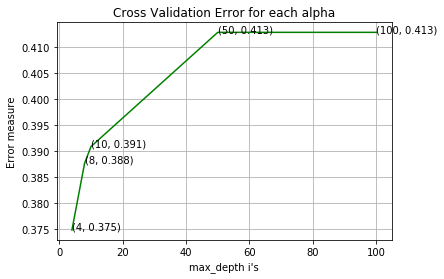

In [86]:
fig, ax = plt.subplots()
ax.plot(max_depth, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((max_depth[i],np.round(txt,3)), (max_depth[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("max_depth i's")
plt.ylabel("Error measure")
plt.show()

In [87]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = max_depth[np.argmin(log_error_array)]

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y_train = bst.predict(d_train)
predict_y_test = bst.predict(d_test)

[06:14:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-logloss:0.684962	valid-logloss:0.68494
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[06:14:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:14:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:14:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:14:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:14:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:14:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:14:50] src/t

[06:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[70]	train-logloss:0.437437	valid-logloss:0.444219
[06:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:14:52] src/tree/updater_prune.cc:74: tree pruning

[06:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[140]	train-logloss:0.38344	valid-logloss:0.397829
[06:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[06:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[06:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[06:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[06:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[06:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[06:14:55] src/tree/updater_prune.cc:74: tree pruning

[06:14:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[210]	train-logloss:0.362237	valid-logloss:0.382665
[06:14:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[06:14:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[06:14:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[06:14:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[06:14:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:14:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[06:14:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:14:56] src/tree/updater_prune.cc:74: tree prunin

[06:14:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[06:14:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[06:14:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:14:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:14:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[06:14:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[06:14:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[06:14:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[06:14:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

In [93]:
print('For values of best depth = ',max_depth[np.argmin(log_error_array)] , "The train log loss is:",log_loss(y_train, predict_y_train, eps=1e-15))
print('For values of best depth = ',max_depth[np.argmin(log_error_array)] , "The test log loss is:",log_loss(y_test, predict_y_test, eps=1e-15))

For values of best depth =  4 The train log loss is: 0.33989452171720436
For values of best depth =  4 The test log loss is: 0.37473050157389065
